### ratio map 之大排組
各種分之 CO(1-0)

湯底是 py_HCN-CO_wask_v2.ipynb，看中它集中取名/存檔的優點  
這邊處理的數據理論上來說解析度是統一的 (by imsmooth)...所以不會再做卷積   
幾個 sigma 的 mom0 也基本決定好了，參考腳本 ../3_mom0_multi-sigma/py_how_many_sigma.ipnb  
由 sigma0 的 mom0 決定的氣體發射區

- 0803  
更新了變數的存放方式，可拓展性變強了

可以輸入東西：  
pixelStep : 投影後的一個 pixel 對應天上多少角秒

In [75]:
# modular

import matplotlib.pyplot as plt
import numpy as np
from astropy.io import fits
from astropy.wcs import WCS
from astropy import units as u 
from reproject import reproject_interp
from radio_beam import Beam

In [76]:
# hand made function

# 存檔芝士
def Save_as_FITS(the_file_name, ima_data, ref_header, ref_beam, beam_a_Beam): 
    the_file_name = the_file_name + '.fits'
    the_header = ref_header.copy() # new header 是複製一個已知 header 的大部分...
    if beam_a_Beam == True: # ref_beam 是實際意義上的 Beam 的話
        the_header['BMAJ'] = ref_beam.major.to(u.deg).value
        the_header['BMIN'] = ref_beam.minor.to(u.deg).value
        the_header['BPA'] = ref_beam.pa.to(u.deg).value
    else: # ref_beam 是一個 header 的話
        the_header['BMAJ'] = ref_beam['BMAJ']
        the_header['BMIN'] = ref_beam['BMIN']
        the_header['BPA'] = ref_beam['BPA']
    fits.writeto(the_file_name, ima_data, the_header, overwrite=True)
    print(f'Successfully saved a new FITS file as {the_file_name}')


# 新網格機！
'''
input a hdul&&像素步長 in arcsec
return new_shape, new_wcs, 和定義的 header 本人 
疑似只能用在我的 CO
'''
def reGrid(reGrid_obj, pixelStep_target): 
    reGrid_obj_header = reGrid_obj[0].header
    ori_n1, ori_n2 = reGrid_obj[0].data.squeeze().shape # (y, x)
    new_n2 = int(ori_n2*abs(reGrid_obj_header['CDELT1']) / (pixelStep_target/3600)) # 要純量相除！
    new_n1 = int(ori_n1*abs(reGrid_obj_header['CDELT2']) / (pixelStep_target/3600))
    new_header = fits.Header()
    new_header['NAXIS'] = 2
    new_header['NAXIS1'] = new_n2
    new_header['NAXIS2'] = new_n1
    new_header['CRPIX1'] = new_n2 * 0.5 + 1
    new_header['CRPIX2'] = new_n1 * 0.5 + 1
    new_header['CRVAL1'] = 213.2915 # 暴力抓蟲
    new_header['CRVAL2'] = -65.339 # 暴力抓蟲
    new_header['CDELT1'] = pixelStep_target / -3600
    new_header['CDELT2'] = pixelStep_target / 3600
    new_header['CTYPE1'] = 'RA---SIN'
    new_header['CTYPE2'] = 'DEC--SIN'
    new_header['CUNIT1'] = 'deg'
    new_header['CUNIT2'] = 'deg'
    new_header['BMAJ'] = reGrid_obj_header['BMAJ']
    new_header['BMIN'] = reGrid_obj_header['BMIN']
    new_header['BPA'] = reGrid_obj_header['BPA']
    print('Giving reprojecting material...')
    return (new_n2, new_n1), WCS(new_header), new_header


In [77]:
# import data
commonPath = '/Users/aqing/Documents/1004/Circinus_galaxy/Ratio-Map/mvp_smoothFirst/3_mom0_multi-sigma/'

# (moleName, parti_fileName, N#signa)
mole_info = [
    ("CO", "CO-1-0", 0.2),
    ("HCN", "HCN-1-0", 0.2),
    ("HCO", "HCO+-1-0", 0.2), # 變數名就不加算符了
    ("CN12", "CN-J12-12", 0.6),
    ("CN32", "CN-J32-12", 0.4),
    ("HNC", "HNC-1-0", 0.6),
    ("CS2", "CS-J2-1", 0.4),
]

# {moleName:{裝資料的小字典}}，未重新投影
ori_data = {}
for mole, filename, nsigma in mole_info:
    hdul = fits.open(f"{commonPath}{filename}_mom0_smoothed-4545_sigma{nsigma}.fits")
    header = hdul[0].header
    image = hdul[0].data.squeeze()
    wcs = WCS(header, naxis=2)
    # 存入資料字典，這樣是雙層字典，方便以鍵取值
    ori_data[mole] = {
        "hdul": hdul,
        "header": header,
        "ima": image,
        "wcs": wcs
    }
# print(ori_data["CO"]["ima"].shape)


Set OBSGEO-B to   -23.022886 from OBSGEO-[XYZ].
Set OBSGEO-H to     5053.796 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


In [78]:
# regridding

pixelStep = 1.13 # arcsec

CO_new_shape, CO_new_wcs, CO_new_header = reGrid(ori_data['CO']['hdul'], pixelStep) # 因為網格機是基於 CO 寫的，所以以 CO 為準
CO_ima_reproj, _ = reproject_interp((ori_data['CO']['ima'], ori_data['CO']['wcs']), CO_new_wcs, shape_out=CO_new_shape)

dataa = {} # 投影過後的 wcs 都是 CO_new_wcs
for mole, _, _ in mole_info:
    if mole == 'CO':
         dataa[mole] = {"new_header": CO_new_header.copy(), "ima_reproj": CO_ima_reproj}
    else:
        ima_reproj, _ = reproject_interp((ori_data[mole]['ima'], ori_data[mole]['wcs']), CO_new_wcs, shape_out=CO_new_shape) # 寄生
        dataa[mole] = {"new_header": CO_new_header.copy(), "ima_reproj": ima_reproj}

# beam
beamKey = ['BMAJ', 'BMIN', 'BPA']
for mole, _, _ in mole_info:
    for i in beamKey:
        dataa[mole]['new_header'][i] = ori_data[mole]['header'][i]

print('FIN')

Giving reprojecting material...
FIN


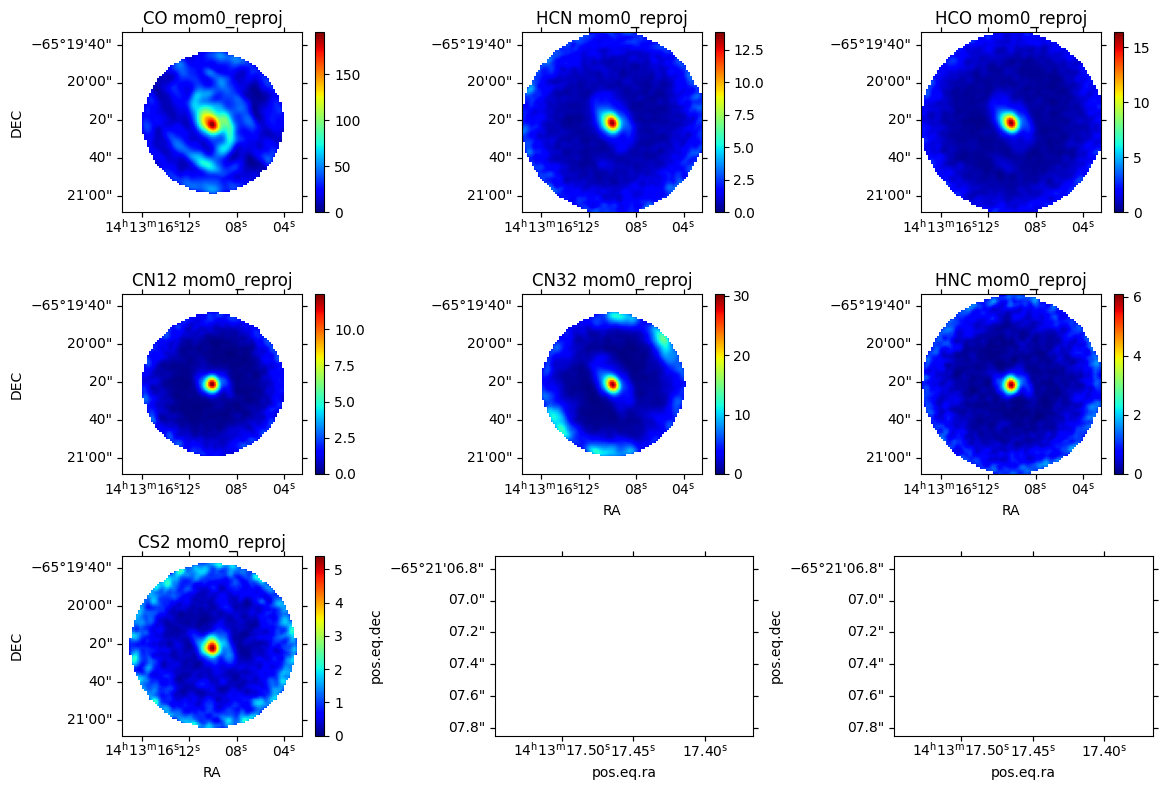

In [79]:
# show the regrid ima
fig_rg, ax = plt.subplots(3, 3, figsize=(12, 8), subplot_kw={'projection': CO_new_wcs})  # 是這樣設座標的
ax_flat = ax.flatten() # 壓成 1d 這樣可以用洄圈

for i, k in enumerate(dataa): # 老豆寫過的那個！
    obj = ax_flat[i].imshow(dataa[k]['ima_reproj'], cmap='jet', vmin=0)
    fig_rg.colorbar(obj, ax=ax_flat[i])
    ax_flat[i].set_title(f"{k} mom0_reproj")

    if i % 3 == 0:
        ax_flat[i].set_ylabel('DEC')
    else:
        ax_flat[i].set_ylabel(' ')
    if i > 3:
        ax_flat[i].set_xlabel('RA')
    else:
        ax_flat[i].set_xlabel(' ')

plt.tight_layout() # 神奇妙妙工具
plt.show()

In [80]:
# ratio mapS

ratio_map = {} # 字典上癮了是吧
for mole, _, _ in mole_info:
    if mole != 'CO':
        ratio = np.where(CO_ima_reproj>2*10**(-3), dataa[mole]['ima_reproj']/CO_ima_reproj, np.nan)
        ratio = np.where(ratio>2.3, np.nan, ratio) # 撇掉一些浮沫
        ratio = np.where(ratio<-4, np.nan, ratio)
        ratio_map[f'{mole}-CO'] = ratio

In [81]:
# 總覺得小調參數的時候還會用到
'''
# HCN/CO
with np.errstate(divide='ignore', invalid='ignore') : 
    ratioMap_HCNCO = np.where(CO_ima_reproj>2*10**(-3), HCN_ima_reproj/CO_ima_reproj, np.nan)
    #ratioMap = np.where(CO_ima_reproj!=0, HCN_ima_reproj/CO_ima_reproj, np.nan)
    ratioMap_HCNCO = np.where(ratioMap_HCNCO>2.3, np.nan, ratioMap_HCNCO) # 撇掉一些浮沫
    ratioMap_HCNCO = np.where(ratioMap_HCNCO<-4, np.nan, ratioMap_HCNCO)

# HCO+/CO
with np.errstate(divide='ignore', invalid='ignore') : 
    ratioMap_HCOCO = np.where(CO_ima_reproj>2*10**(-3), HCO_ima_reproj/CO_ima_reproj, np.nan)
    ratioMap_HCOCO = np.where(ratioMap_HCOCO>2.3, np.nan, ratioMap_HCOCO)
    ratioMap_HCOCO = np.where(ratioMap_HCOCO<-4, np.nan, ratioMap_HCOCO)

# CN/CO
with np.errstate(divide='ignore', invalid='ignore') : 
    ratioMap_CNCO = np.where(CO_ima_reproj>2*10**(-3), CN_ima_reproj/CO_ima_reproj, np.nan)
    ratioMap_CNCO = np.where(ratioMap_CNCO>2.3, np.nan, ratioMap_CNCO)
    ratioMap_CNCO = np.where(ratioMap_CNCO<-4, np.nan, ratioMap_CNCO)

# HNC/CO
with np.errstate(divide='ignore', invalid='ignore') : 
    ratioMap_HNCCO = np.where(CO_ima_reproj>2*10**(-3), HNC_ima_reproj/CO_ima_reproj, np.nan)
    ratioMap_HNCCO = np.where(ratioMap_HNCCO>2.3, np.nan, ratioMap_HNCCO)
    ratioMap_HNCCO = np.where(ratioMap_HNCCO<-4, np.nan, ratioMap_HNCCO)

# CS(2-1)/CO
with np.errstate(divide='ignore', invalid='ignore') : 
    ratioMap_CS2CO = np.where(CO_ima_reproj>2*10**(-3), CS2_ima_reproj/CO_ima_reproj, np.nan)
    ratioMap_CS2CO = np.where(ratioMap_CS2CO>2.3, np.nan, ratioMap_CS2CO)
    ratioMap_CS2CO = np.where(ratioMap_CS2CO<-4, np.nan, ratioMap_CS2CO)
'''

"\n# HCN/CO\nwith np.errstate(divide='ignore', invalid='ignore') : \n    ratioMap_HCNCO = np.where(CO_ima_reproj>2*10**(-3), HCN_ima_reproj/CO_ima_reproj, np.nan)\n    #ratioMap = np.where(CO_ima_reproj!=0, HCN_ima_reproj/CO_ima_reproj, np.nan)\n    ratioMap_HCNCO = np.where(ratioMap_HCNCO>2.3, np.nan, ratioMap_HCNCO) # 撇掉一些浮沫\n    ratioMap_HCNCO = np.where(ratioMap_HCNCO<-4, np.nan, ratioMap_HCNCO)\n\n# HCO+/CO\nwith np.errstate(divide='ignore', invalid='ignore') : \n    ratioMap_HCOCO = np.where(CO_ima_reproj>2*10**(-3), HCO_ima_reproj/CO_ima_reproj, np.nan)\n    ratioMap_HCOCO = np.where(ratioMap_HCOCO>2.3, np.nan, ratioMap_HCOCO)\n    ratioMap_HCOCO = np.where(ratioMap_HCOCO<-4, np.nan, ratioMap_HCOCO)\n\n# CN/CO\nwith np.errstate(divide='ignore', invalid='ignore') : \n    ratioMap_CNCO = np.where(CO_ima_reproj>2*10**(-3), CN_ima_reproj/CO_ima_reproj, np.nan)\n    ratioMap_CNCO = np.where(ratioMap_CNCO>2.3, np.nan, ratioMap_CNCO)\n    ratioMap_CNCO = np.where(ratioMap_CNCO<-4, np.n

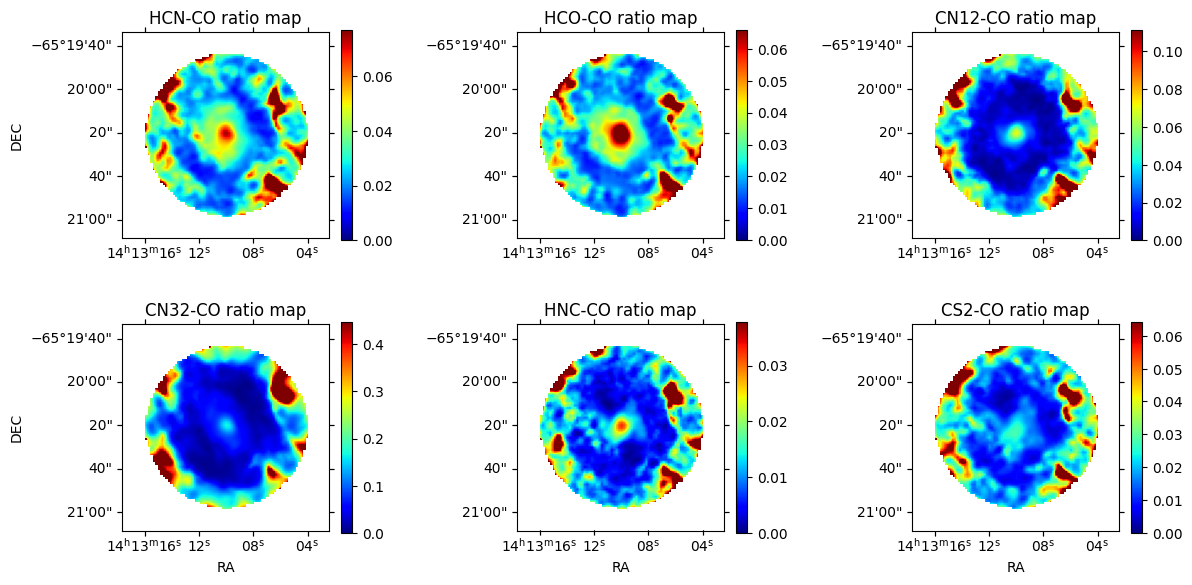

In [82]:
# show the regrid ima
# 反正只是預覽
fig_rg, ax = plt.subplots(2, 3, figsize=(12, 6), subplot_kw={'projection': CO_new_wcs})
ax_flat = ax.flatten()

for i, k in enumerate(ratio_map): 
    ima_here = ratio_map[k]
    obj = ax_flat[i].imshow(ima_here, origin='lower', cmap='jet', vmin=0, vmax=np.nanpercentile(ima_here, 95))
    fig_rg.colorbar(obj, ax=ax_flat[i])
    ax_flat[i].set_title(f"{k} ratio map")

    if i % 3 == 0:
        ax_flat[i].set_ylabel('DEC')
    else:
        ax_flat[i].set_ylabel(' ')
    if i > 2:
        ax_flat[i].set_xlabel('RA')
    else:
        ax_flat[i].set_xlabel(' ')

plt.tight_layout() # 神奇妙妙工具
plt.show()

In [ ]:
# save all file

'''
# regrid
Save_as_FITS(f'CO-1-0_mom0_smoothed-4545_sigma0.2_regrid{pixelStep}', CO_ima_reproj, CO_new_header, CO_new_header, False)
Save_as_FITS(f'HCN-1-0_mom0_smoothed-4545_sigma0.2_regrid{pixelStep}.fits', HCN_ima_reproj, CO_new_header, HCN_new_header, False)
Save_as_FITS(f'HCO+-1-0_mom0_smoothed-4545_sigma0.2_regrid{pixelStep}.fits', HCO_ima_reproj, HCO_new_header, HCO_new_header, False)
Save_as_FITS(f'CN-J12-12_mom0_smoothed-4545_sigma0.8_regrid{pixelStep}.fits', CN_ima_reproj, CN_new_header, CN_new_header, False)
Save_as_FITS(f'HNC-1-0_mom0_smoothed-4545_sigma0.4_regrid{pixelStep}.fits', HNC_ima_reproj, HNC_new_header, HNC_new_header, False)
Save_as_FITS(f'CS-J2-1_mom0_smoothed-4545_sigma0.2_regrid{pixelStep}.fits', CS2_ima_reproj, CS2_new_header, CS2_new_header, False)
'''

# ratio
for k in ratio_map:
    Save_as_FITS(f"{k}_ratio_regrid{pixelStep}", ratio_map[k], CO_new_header, CO_new_header, False)

HCN-CO
Successfully saved a new FITS file as HCN-CO_ratio_regrid1.13.fits
HCO-CO
Successfully saved a new FITS file as HCO-CO_ratio_regrid1.13.fits
CN12-CO
Successfully saved a new FITS file as CN12-CO_ratio_regrid1.13.fits
CN32-CO
Successfully saved a new FITS file as CN32-CO_ratio_regrid1.13.fits
HNC-CO
Successfully saved a new FITS file as HNC-CO_ratio_regrid1.13.fits
CS2-CO
Successfully saved a new FITS file as CS2-CO_ratio_regrid1.13.fits
